In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from monai.transforms import LoadImaged, Compose, Resized, EnsureChannelFirstd

# Add the project source to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import your custom transform
from src.data.transforms import RidgeletTransformd

# Set notebook style
plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete.")

Setup complete.


In [2]:
# Load environment variables
load_dotenv(dotenv_path='../.env')
IMAGE_ROOT_DIR = os.getenv("MIMIC_CXR_P_FOLDERS_PATH")
PROJECT_DATA_FOLDER_PATH = os.getenv("PROJECT_DATA_FOLDER_PATH")

if not all([IMAGE_ROOT_DIR, PROJECT_DATA_FOLDER_PATH]):
    raise ValueError("Please ensure all required environment variables are set.")

# --- 1. Load data and select a sample with a fracture ---
val_csv_path = os.path.join(PROJECT_DATA_FOLDER_PATH, "splits", "split_2000", "validation.csv")
df_val = pd.read_csv(val_csv_path)

df_fractures = df_val[df_val['fracture'] == 1]
if df_fractures.empty:
    raise ValueError("No fracture cases found in the validation split.")

# Get image path
sample_record = df_fractures.iloc[0]
subject_id = str(int(sample_record['subject_id']))
study_id = str(int(sample_record['study_id']))
dicom_id = str(sample_record['dicom_id'])
image_relative_path = os.path.join(f"p{subject_id[:2]}", f"p{subject_id}", f"s{study_id}", f"{dicom_id}.jpg")
full_image_path = os.path.join(IMAGE_ROOT_DIR, image_relative_path)

sample_dict = {"image": full_image_path}
print(f"Successfully located image with a fracture:\n{full_image_path}")

Successfully located image with a fracture:
E:/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/files\p19\p19175595\s52445151\468a1675-344a56da-7cf12651-0344086a-8454a87a.jpg


In [4]:
# --- Configuration for Visualization ---
SQUARE_SIZE = 512

# --- Base Preprocessing ---
base_pipeline = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Resized(keys=["image"], spatial_size=(SQUARE_SIZE, SQUARE_SIZE)),
])
preprocessed_dict = base_pipeline(sample_dict)
original_image_tensor = preprocessed_dict['image']

# --- Define and Apply the Ridgelet Transform ---
# The new RidgeletTransformd automatically uses BayesShrink.
# The `sparsity_level` parameter is no longer needed.
print("Applying Ridgelet Transform with BayesShrink Denoising...")
ridgelet_transformer = RidgeletTransformd(keys=["image"])
denoised_result = ridgelet_transformer(preprocessed_dict.copy())

print("\nRidgelet transform applied successfully.")

Applying Ridgelet Transform with BayesShrink Denoising...


c:\Users\joaco\anaconda3\envs\Magister\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(



Ridgelet transform applied successfully.


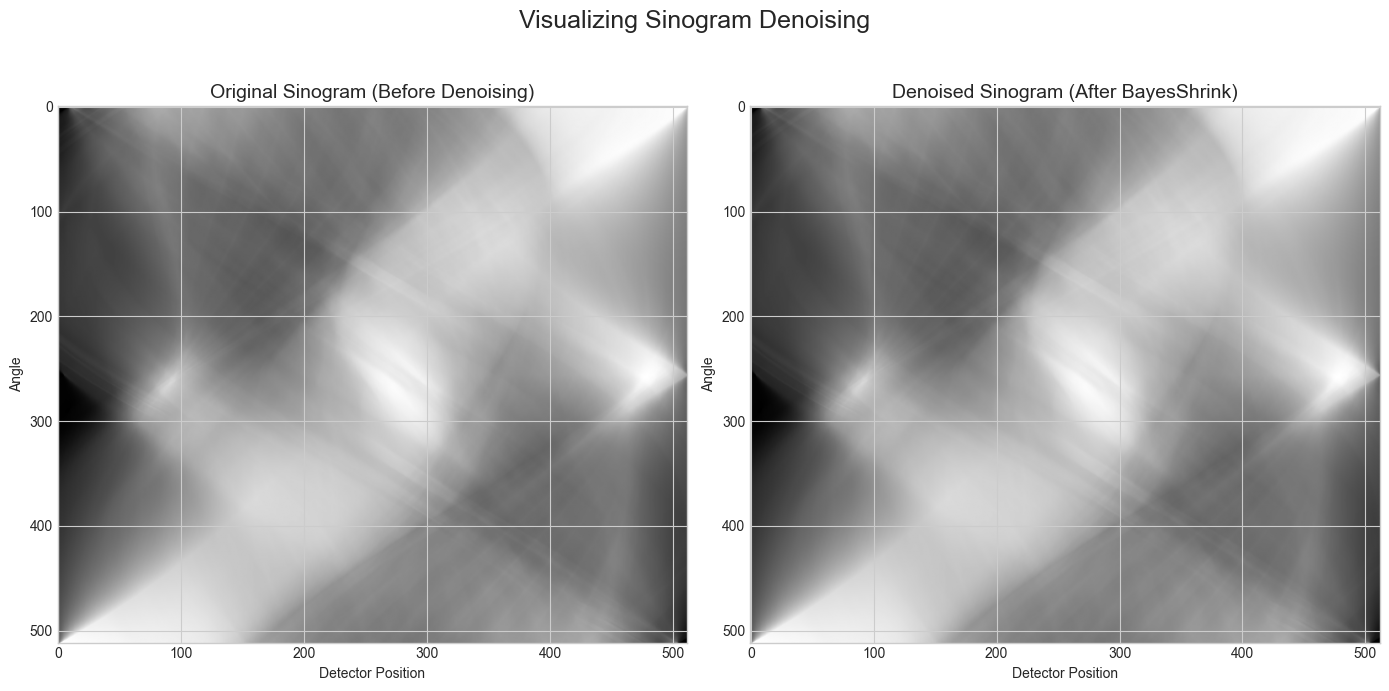

In [ ]:
from skimage.transform import radon
import numpy as np

# --- Visualize the Denoised Sinogram ---
# This shows the direct output of feature extraction.

# --- 1. Generate the original, non-denoised sinogram using scikit-image ---
original_image_np = original_image_tensor.squeeze().cpu().numpy()
theta = np.linspace(0., 180., max(original_image_np.shape), endpoint=False)
original_sinogram_np = radon(original_image_np, theta=theta, circle=True)


# --- 2. Generate the denoised sinogram using the transform ---
sino_transformer = RidgeletTransformd(
    keys=["image"],
    output_type='sinogram' 
)
denoised_sino_result = sino_transformer(preprocessed_dict.copy())


# --- 3. Prepare Tensors for Plotting ---
# The denoised sinogram is a tensor, so we convert it to numpy
denoised_sino_np = denoised_sino_result['image'].squeeze().cpu().numpy()


# --- 4. Create a figure to display sinogram results ---
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Visualizing Sinogram Denoising", fontsize=18)

# Plot Original Sinogram
# We transpose the skimage output to match our convention (angles, detectors)
axes[0].imshow(original_sinogram_np.T, cmap='gray', aspect='auto')
axes[0].set_title('Original Sinogram (Before Denoising)', fontsize=14)
axes[0].set_xlabel('Detector Position')
axes[0].set_ylabel('Angle')

# Plot Denoised Sinogram
axes[1].imshow(denoised_sino_np, cmap='gray', aspect='auto')
axes[1].set_title('Denoised Sinogram (After BayesShrink)', fontsize=14)
axes[1].set_xlabel('Detector Position')
axes[1].set_ylabel('Angle')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

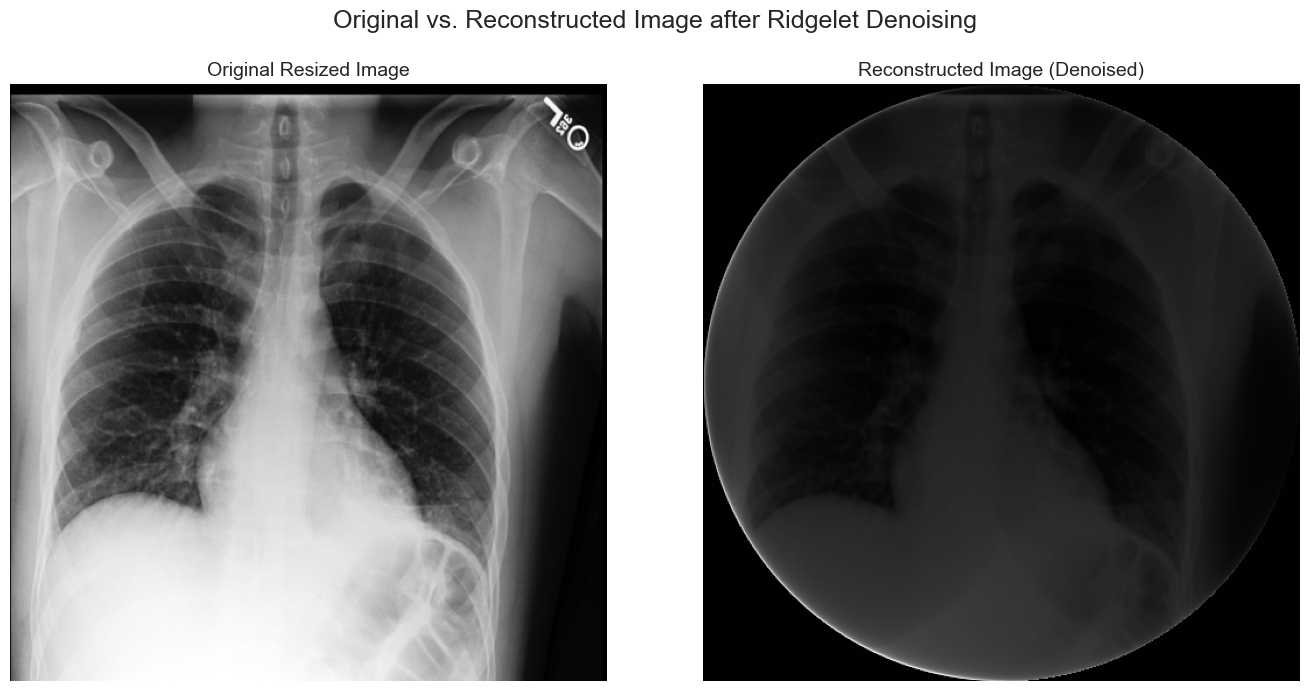

In [7]:
# --- Visualize the Reconstructed Image ---
# This applies the full forward and inverse transform to see the final denoised image.

# 1. Define the transformer for reconstruction output
recon_transformer = RidgeletTransformd(
    keys=["image"],
    output_type='reconstruction'  # This is the default, but we make it explicit
)

# 2. Apply the transform
recon_result = recon_transformer(preprocessed_dict.copy())


# 3. Prepare Tensors for Plotting
original_np = original_image_tensor.squeeze().cpu().numpy()
reconstructed_np = recon_result['image'].squeeze().cpu().numpy()


# 4. Create a figure to display the results
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Original vs. Reconstructed Image after Ridgelet Denoising", fontsize=18)

# Plot Original Image
axes[0].imshow(original_np.T, cmap='gray')
axes[0].set_title('Original Resized Image', fontsize=14)
axes[0].axis('off')

# Plot Reconstructed Image
axes[1].imshow(reconstructed_np.T, cmap='gray')
axes[1].set_title('Reconstructed Image (Denoised)', fontsize=14)
axes[1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()